# 脸部特征

脸部特征由68个基本点组成

<img src="facial_landmarks_68markup-1024x825.jpg" alt="Drawing" style="width: 400px;"/>

In [1]:
import sys
import numpy as np
import math 
from imutils import face_utils
from collections import OrderedDict
import cv2
import argparse
import imutils
import dlib

sys.path.append('..')
from opencv_course import ImageUtil

In [2]:
def rect_to_bb(rect):
    # take a bounding predicted by dlib and convert it
    # to the format (x, y, w, h) as we would normally do
    # with OpenCV
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y

    # return a tuple of (x, y, w, h)
    return (x, y, w, h)

def distance_p2line(p, l1, l2):
    return np.linalg.norm(np.cross(l2-l1, l1-p))/np.linalg.norm(l2-l1)

def distance(p1, p2):
    x1, y1 = p1
    x2, y2 = p2
    return math.sqrt(math.pow(x2 - x1, 2) + math.pow(y2 - y1, 2) * 1.0) 

def trim_img(img):
    y,x = img[:,:,3].nonzero()
    minx = np.min(x)
    miny = np.min(y)
    maxx = np.max(x)
    maxy = np.max(y) 
    return img[miny:maxy, minx:maxx]

def find_point(p1, p2, ratio=0.5):
    return ((int)(p1[0]*ratio+p2[0]*(1-ratio)), (int)(p1[1]*ratio+p2[1]*(1-ratio)))

def find_left_maxy(img):
    y = img[:,0,3].nonzero()
    return np.min(y)

def eye_angle(p1, p2):
    return math.atan(abs((p2[1]-p1[1])/(p2[0] - p1[0]))) * 180 / math.pi - 13

#判断是否右脸特别大
def big_right(shape):
    left_edge = shape[2]
    left_nose = shape[31]
    right_edge = shape[14]
    right_nose = shape[35]
    return distance(left_edge, left_nose)*1.1 < distance(right_edge, right_nose)

In [3]:
# initialize dlib's face detector (HOG-based) and then create
# the facial landmark predictor
shape_predictor = '../../detector/shape_predictor_68_face_landmarks.dat'

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(shape_predictor)

<Figure size 1080x720 with 0 Axes>

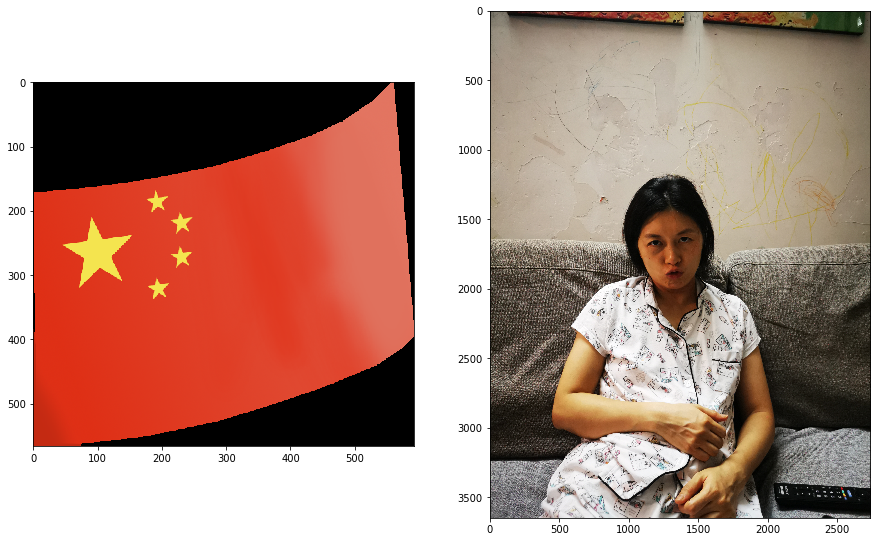

In [4]:
# load the input image, resize it, and convert it to grayscale
image = cv2.imread('dd.jpg')
# image = imutils.resize(image, width=500)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

flag = cv2.imread('flag4.png', -1)
flag = trim_img(flag)

# detect faces in the grayscale image
rects = detector(gray, 1)

ImageUtil.imshow([flag,image], columns=2, figsize=(15,10))

In [5]:
# loop over the face detections
for (i, rect) in enumerate(rects):
    # etermine the facial landmarks for the face region, then
    # convert the facial landmark (x, y)-coordinates to a NumPy
    # array
    shape = predictor(gray, rect)
    shape = face_utils.shape_to_np(shape)

    # convert dlib's rectangle to a OpenCV-style bounding box
    # [i.e., (x, y, w, h)], then draw the face bounding box
    (x, y, w, h) = face_utils.rect_to_bb(rect)

    # loop over the (x, y)-coordinates for the facial landmarks
    # and draw them on the image
#     i=1
#     for (x, y) in shape:
#         cv2.circle(image, (x, y), 1, (0, 255, 0), -1)
#         i+=1

    point = find_point(shape[35],shape[47],0.5)
#     cv2.line(image, (shape[35][0], shape[35][1]),(shape[47][0],shape[47][1]) ,(0, 255, 0),1)
#     cv2.circle(image, point, 1, (0, 255, 0), -1)

    angle = eye_angle(shape[42],shape[45])
    print(angle)
    flag = trim_img(imutils.rotate_bound(flag, -1*angle))

    h, w = flag.shape[:2]
    print(big_right(shape))
    p = 13 if not big_right(shape) else 11 if abs(angle) < 11 else 12
    new_w = shape[p][0]-point[0]
    rate = new_w/w
    new_h = h * rate

    x,y = point
    y-=(int)(new_h/2)

    overlay_size = ((int)(new_w), (int)(new_h))

    if overlay_size is not None:
        img_to_overlay_t = cv2.resize(flag.copy(), overlay_size)

    # Extract the alpha mask of the RGBA image, convert to RGB 
    b,g,r,a = cv2.split(img_to_overlay_t)
    overlay_color = cv2.merge((b,g,r))
    #如果不用threshold，就容易有白点或黑点
    (thresh, blackAndWhiteMask) = cv2.threshold(a, 127, 255, cv2.THRESH_BINARY)

    # Apply some simple filtering to remove edge noise
    mask = cv2.medianBlur(a,5)
    h, w, _ = overlay_color.shape
    roi = image[y:y+h, x:x+w]

    # Black-out the area behind the logo in our original ROI
    img1_bg = cv2.bitwise_and(roi.copy(),roi.copy(),mask = cv2.bitwise_not(blackAndWhiteMask))

    # Mask out the logo from the logo image.
    img2_fg = cv2.bitwise_and(overlay_color,overlay_color,mask = blackAndWhiteMask)

    # Update the original image with our new ROI
    image[y:y+h, x:x+w] = cv2.add(img1_bg, img2_fg)

2.068488159492208
False
-8.914383220025123
True


<Figure size 1080x720 with 0 Axes>

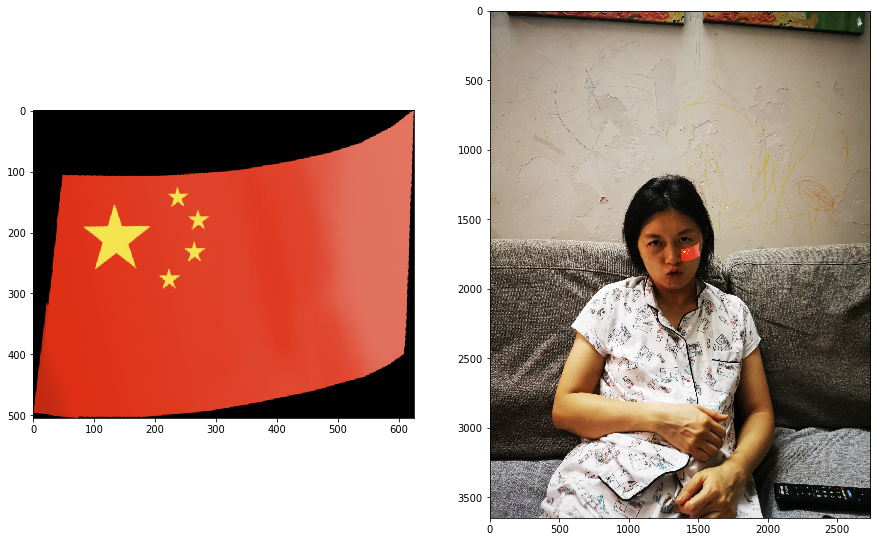

True

In [6]:
ImageUtil.imshow([flag,image], columns=2, figsize=(15,10))

cv2.imwrite("face.jpg", image)